In [0]:
import numpy as np
import torch

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

epochs = 5
learning_rate= 0.1
momentum=0.5

In [2]:
# Values for Normalize() are the global mean and
# standard deviation of the MNIST dataset
transform = transforms.Compose([lambda img: transforms.functional.rotate(img, -90, fill=(0,)),
                                lambda img: transforms.functional.hflip(img),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.EMNIST('dataset/', split='byclass', train=True,
                             download=True, transform=transform)

test_data = datasets.EMNIST('dataset/', split='byclass', train=False,
                            download=True, transform=transform)


Extracting dataset/EMNIST/raw/emnist.zip to dataset/EMNIST/raw
Processing byclass
Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [0]:
train_loader = DataLoader(train_data,
                          batch_size=64,
                          shuffle=True)

test_loader = DataLoader(test_data,
                         batch_size=1000,
                         shuffle=True)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.dropout = nn.Dropout()  # Dropout to prevent overfitting
        self.fc1 = nn.Linear(7 * 7 * 256, 512)
        self.fc2 = nn.Linear(512, 62)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.softmax(out)

        return out

In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
cnn = Net()
cnn.to(device)

cuda


Net(
  (layer1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=62, bias=True)
  (softmax): LogSoftmax()
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate, momentum=momentum)
def train(epoch_n):
    running_loss = 0
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        output = cnn(images)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if idx % 100 == 0:
            print('Epoch {} -> [{}/{} ({:.0f}%)] Loss: {:.6}'.format(
                epoch_n, idx * len(images), len(train_loader.dataset),
                100. * idx / len(train_loader), running_loss/len(train_loader))
            )
        

In [0]:
def test():
    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = cnn(images)
            
            predicted_label = output.data.max(1, keepdim=True)[1]
            correct += predicted_label.eq(labels.
                                          data.view_as(predicted_label)).sum()
        
            loss = criterion(output, labels)
            test_loss += loss.item()
        
        test_loss /= len(test_loader.dataset)

In [8]:
test()
for e in range(1, epochs + 1):
    train(e)
    test()


Accuracy = 0.58%
Epoch 1 -> [0/697932 (0%)] Loss: 0.00037627
Epoch 1 -> [6400/697932 (1%)] Loss: 0.0182136
Epoch 1 -> [12800/697932 (2%)] Loss: 0.0271421
Epoch 1 -> [19200/697932 (3%)] Loss: 0.0346773
Epoch 1 -> [25600/697932 (4%)] Loss: 0.0418186
Epoch 1 -> [32000/697932 (5%)] Loss: 0.0484314
Epoch 1 -> [38400/697932 (6%)] Loss: 0.0546063
Epoch 1 -> [44800/697932 (6%)] Loss: 0.060403
Epoch 1 -> [51200/697932 (7%)] Loss: 0.0663319
Epoch 1 -> [57600/697932 (8%)] Loss: 0.0720033
Epoch 1 -> [64000/697932 (9%)] Loss: 0.0774526
Epoch 1 -> [70400/697932 (10%)] Loss: 0.0829084
Epoch 1 -> [76800/697932 (11%)] Loss: 0.0882281
Epoch 1 -> [83200/697932 (12%)] Loss: 0.0934637
Epoch 1 -> [89600/697932 (13%)] Loss: 0.0987242
Epoch 1 -> [96000/697932 (14%)] Loss: 0.103765
Epoch 1 -> [102400/697932 (15%)] Loss: 0.108594
Epoch 1 -> [108800/697932 (16%)] Loss: 0.113599
Epoch 1 -> [115200/697932 (17%)] Loss: 0.118512
Epoch 1 -> [121600/697932 (17%)] Loss: 0.123317
Epoch 1 -> [128000/697932 (18%)] Loss: 0

In [0]:
def prediction_figure(img, prob, pred):
    prob = prob.cpu().data.numpy().squeeze()
    fig, ax1 = plt.subplots(figsize=(3, 3), ncols=1)
    ax1.set_title('Predicted Digit = {}'.format(str(pred)))
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    plt.tight_layout()

In [0]:
def view_prediction():
    images, labels = next(iter(test_loader))
    # Turn off gradients to speed up this part
    with torch.no_grad():
        output = cnn(images.to(device))
    # Convert the log-probability for checking probability of each class
    probability = torch.exp(output)
    prediction = list(output.cpu().numpy()[0])
    classes = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    max_pred = prediction.index(max(prediction))
    real_pred = classes[max_pred]

    prediction_figure(images, probability, real_pred)

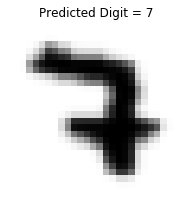

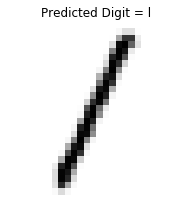

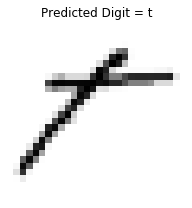

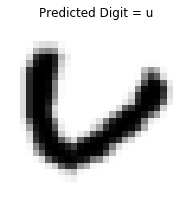

In [20]:
for x in range(4):
  view_prediction()

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'letter_model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(cnn.state_dict(), path)